## NLP Example



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import IMDB
from collections import Counter, OrderedDict
from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# Load the IMDB dataset
train_iter, test_iter = IMDB(split=('train', 'test'))

tokenizer = get_tokenizer('spacy')

counter = Counter()
for (label, text) in train_iter:
    counter.update(tokenizer(text))

/Users/andrei/miniforge3/envs/rdl/lib/python3.9/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [2]:
# # Add special tokens to the counter
specials = ['<pad>', '<bos>', '<eos>', '<unk>']
ordered_dict = OrderedDict([(token, 1) for token, _ in counter.items()])

v1 = vocab(ordered_dict, specials=specials)
v1.set_default_index(-1)
v1.set_default_index(v1['<unk>'])
print(f"Vocabulary size: {len(v1)}")


Vocabulary size: 121069


In [3]:
text_transform = lambda x: [v1['<bos>']] + [v1[token] for token in tokenizer(x)] + [v1['<eos>']]
label_transform = lambda x: 0 if x == 1 else 1 # 0 for negative, 1 for positive

def collate_batch(batch):
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(label_transform(_label))
        processed_text = torch.tensor(text_transform(_text))
        # print(f"Max token index: {processed_text.max()}")  # Add this line to print the maximum token index
        text_list.append(processed_text)
    return pad_sequence(text_list, batch_first=True, padding_value=v1['<pad>']), torch.tensor(label_list)

BATCH_SIZE = 128
train_dataloader = DataLoader(list(train_iter), batch_size=BATCH_SIZE, shuffle=True, 
                              collate_fn=collate_batch)

test_dataloader = DataLoader(list(test_iter), batch_size=BATCH_SIZE, shuffle=True, 
                              collate_fn=collate_batch)

In [4]:
from tda.activation import TDA

class TDANLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, time_window, max_value, scaling_factor, dropout=0.5):
        super(TDANLP, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.tda = TDA(time_window, max_value, scaling_factor)
        # self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x.transpose(1, 2)  # Transpose to have the time_window dimension as the last dimension
        x = self.tda(x)
        # x = self.dropout(x)
        x = self.fc(x)
        return x

In [5]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = torch.round(torch.sigmoid(outputs))
        correct += (predictions == labels).sum().item()
        total += len(labels)

    return total_loss / len(dataloader), correct / total


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())

            total_loss += loss.item()
            predictions = torch.round(torch.sigmoid(outputs))
            correct += (predictions == labels).sum().item()
            total += len(labels)

    return total_loss / len(dataloader), correct / total


def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_dataloader, criterion, optimizer, device)
        test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    return train_losses, test_losses, train_accuracies, test_accuracies

In [6]:
print(f"Vocabulary size: {len(v1)}")

# Hyperparameters
vocab_size =  len(v1)+1 # 121069 !335746+1
embedding_dim = 100
hidden_size = 64
output_size = 1
time_window = 50
max_value = 10
scaling_factor = 1
num_epochs = 15
learning_rate = 0.001
weight_decay = 1e-4
dropout = 0.2

Vocabulary size: 121069


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.has_mps else 'cpu')
print(f'Device: {device}')
# Initialize the model, criterion, and optimizer
model = TDANLP(vocab_size, embedding_dim, hidden_size, output_size, time_window, max_value, scaling_factor, dropout=dropout).to(device)
if torch.cuda.is_available():
    # experimental
    model = torch.compile(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # weight_decay=weight_decay)

# Train the model
train_losses, test_losses, train_accuracies, test_accuracies = train_model(model, train_dataloader, test_dataloader, criterion, optimizer, device, num_epochs)


Device: mps
Epoch 1/15
Train Loss: 0.6932, Train Accuracy: 0.4992
Test Loss: 0.6931, Test Accuracy: 0.5001
Epoch 2/15
Train Loss: 0.6930, Train Accuracy: 0.4914
Test Loss: 0.6925, Test Accuracy: 0.5000
Epoch 3/15
Train Loss: 0.6915, Train Accuracy: 0.4950
Test Loss: 0.6934, Test Accuracy: 0.4664
Epoch 4/15
Train Loss: 0.6840, Train Accuracy: 0.5780
Test Loss: 0.6874, Test Accuracy: 0.5848
Epoch 5/15
Train Loss: 0.6606, Train Accuracy: 0.6694
Test Loss: 0.6503, Test Accuracy: 0.6700
Epoch 6/15
Train Loss: 0.6008, Train Accuracy: 0.7473
Test Loss: 0.6448, Test Accuracy: 0.6551
Epoch 7/15
Train Loss: 0.5585, Train Accuracy: 0.7693
Test Loss: 0.5678, Test Accuracy: 0.7324
Epoch 8/15
Train Loss: 0.4781, Train Accuracy: 0.8247
Test Loss: 0.5456, Test Accuracy: 0.7372
Epoch 9/15
Train Loss: 0.4232, Train Accuracy: 0.8517
Test Loss: 0.5226, Test Accuracy: 0.7469
Epoch 10/15
Train Loss: 0.3754, Train Accuracy: 0.8735
Test Loss: 0.5221, Test Accuracy: 0.7530
Epoch 11/15
Train Loss: 0.3309, Train

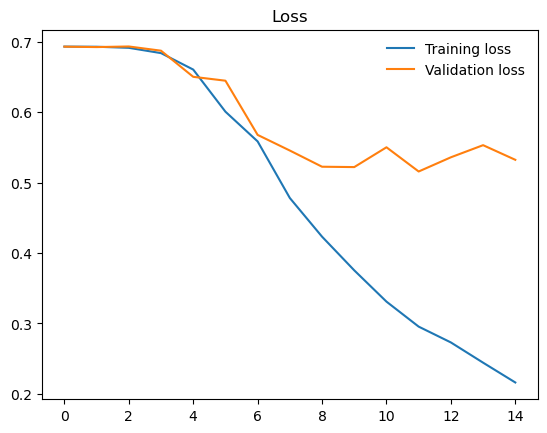

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss')
plt.legend(frameon=False)
plt.show()

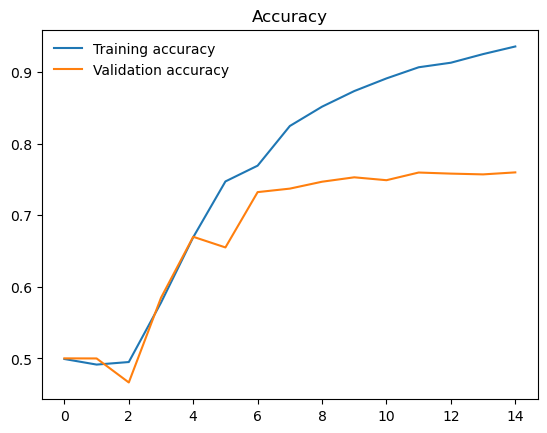

In [9]:
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(test_accuracies, label='Validation accuracy')
plt.title('Accuracy')
plt.legend(frameon=False)
plt.show()

In [10]:
def class_to_label(class_index):
    return "pos" if class_index == 1 else "neg"

def convert_output_to_text(model_output):
    # Apply the sigmoid activation function to get the probabilities
    probabilities = torch.sigmoid(model_output)
    
    # Convert probabilities to class indices (0 or 1)
    class_indices = (probabilities > 0.5).long()
    
    # Convert class indices to labels
    labels = [class_to_label(index) for index in class_indices]
    
    return labels


In [11]:
# Get a single batch of test data
test_inputs, test_labels = next(iter(test_dataloader))
test_inputs = test_inputs.to(device)

# Get the model output
model.eval()
with torch.no_grad():
    model_output = model(test_inputs).squeeze()


def tokens_to_text(token_tensor, show_special_tokens=False):
    return ' '.join([v1.get_itos()[index.item()] for index in token_tensor if show_special_tokens or index.item() > 3])


# Convert test_inputs back to text
for i in range(5):
    input_text = tokens_to_text(test_inputs[i])
    print(
        f'Input: {input_text} \n({class_to_label(test_labels[i].item())}) -> Output: {class_to_label(model_output[i])}')


Input: OK , it was a " risky " move to rent this flick , but I thought I had nothing to lose . Well , I was wrong . This is , next to " " , the worst " horrormovie " I have ever seen . Crappy actors , crappy technical output , crappy story and so on . The soundtrack though , is n't to bad . That is why I give it a 2 on the vote and not just a 1 . And of course the cats are a positive surprise . By far the superior actors in this movie ..... Do not rent or buy it . Stay away from it and hope that this horrible , horrible film will vanish to some obscure existence and not become a " cult classic " . It most definitely do not deserve any recognition . 
(neg) -> Output: neg
Input: The Capture Of Bigfoot is one of the silliest and worst movies of all time . I love Sasquatch and Bigfoot movies but this one is just a sheer waste of one 's time . Terrible , terrible , terrible!I watched this movie last night , and it was all I could do to finish watching . I understood that this weird crazy ma

## Simple NLP
Creating a model without TDA to compare performance.

In [12]:
class SimpleNLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, dropout=0.5, ac=nn.ReLU):
        super(SimpleNLP, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.ac = ac()
        # self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1]  # Use the last time step output as input to the fully connected layer
        x = self.ac(x)
        # x = self.dropout(x)
        x = self.fc(x)
        return x


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.has_mps else 'cpu')
print(f'Device: {device}')
# Initialize the model, criterion, and optimizer
model_no_tda = SimpleNLP(vocab_size, embedding_dim, hidden_size, output_size, dropout=dropout).to(device)
if torch.cuda.is_available():
    # experimental
    model_no_tda = torch.compile(model_no_tda)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_no_tda.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train the model without TDA
train_losses_no_tda, test_losses_no_tda, train_accuracies_no_tda, test_accuracies_no_tda = train_model(model_no_tda, train_dataloader, test_dataloader, criterion, optimizer, device, 10)


Device: mps
Epoch 1/10
Train Loss: 0.6943, Train Accuracy: 0.4943
Test Loss: 0.6933, Test Accuracy: 0.5016
Epoch 2/10
Train Loss: 0.6932, Train Accuracy: 0.5070
Test Loss: 0.6931, Test Accuracy: 0.5066
Epoch 3/10
Train Loss: 0.6931, Train Accuracy: 0.5065
Test Loss: 0.6932, Test Accuracy: 0.5011
Epoch 4/10
Train Loss: 0.6931, Train Accuracy: 0.5034
Test Loss: 0.6929, Test Accuracy: 0.5062
Epoch 5/10
Train Loss: 0.6930, Train Accuracy: 0.5053
Test Loss: 0.6930, Test Accuracy: 0.5047
Epoch 6/10
Train Loss: 0.6930, Train Accuracy: 0.5014
Test Loss: 0.6929, Test Accuracy: 0.5080
Epoch 7/10
Train Loss: 0.6932, Train Accuracy: 0.5097
Test Loss: 0.6932, Test Accuracy: 0.5040
Epoch 8/10
Train Loss: 0.6932, Train Accuracy: 0.4999
Test Loss: 0.6930, Test Accuracy: 0.5039
Epoch 9/10
Train Loss: 0.6932, Train Accuracy: 0.5018
Test Loss: 0.6931, Test Accuracy: 0.5013
Epoch 10/10
Train Loss: 0.6932, Train Accuracy: 0.5026
Test Loss: 0.6930, Test Accuracy: 0.5088


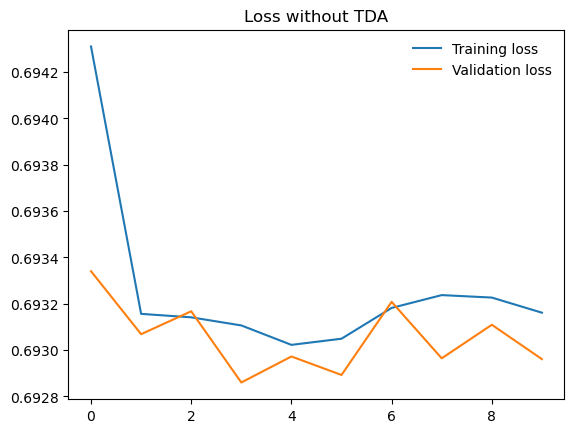

In [14]:
plt.plot(train_losses_no_tda, label='Training loss')
plt.plot(test_losses_no_tda, label='Validation loss')
plt.title('Loss without TDA')
plt.legend(frameon=False)
plt.show()

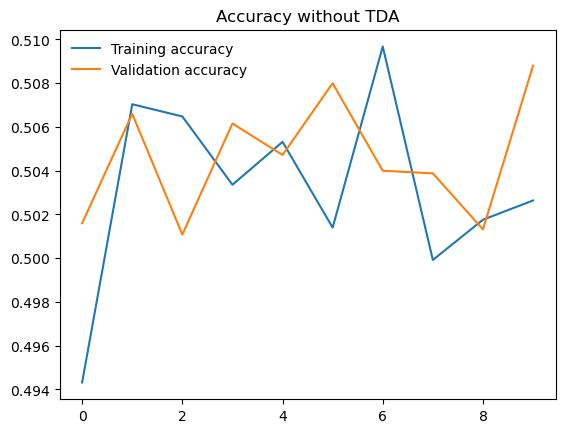

In [15]:
plt.plot(train_accuracies_no_tda, label='Training accuracy')
plt.plot(test_accuracies_no_tda, label='Validation accuracy')
plt.title('Accuracy without TDA')
plt.legend(frameon=False)
plt.show()

## Conclusion

Based on the results, it can be observed that the model trained with the TDA activation function outperforms the model without TDA. The model with TDA shows significant improvement in both training and test accuracy over the 10 epochs, whereas the model without TDA struggles to learn from the data, with its accuracy hovering around 50% for both training and test sets.

In conclusion, incorporating the TDA activation function into your neural network model seems to have a positive impact on the model's performance. The TDA activation function's ability to emphasize recent information and diminish the influence of older data appears to benefit the model's learning process. This could be particularly useful for time-dependent data, where the relative importance of information changes over time.

> It is important to keep in mind that these conclusions are based on a single experiment, and it would be valuable to conduct additional experiments with different datasets, architectures, and hyperparameters to further validate the effectiveness of the TDA activation function.